# Plots for manuscript case study 

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import os, sys
sys.path.append(os.pardir)
import requests
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
from arviz.stats.density_utils import _kde_linear

from app.prediction.predict import impute, predict_mortality
from app.Fixtures.constants import RANDOM_SEED
from app.Fixtures.gams import (
    study_export,
    LACTATE_GAM,
    ALBUMIN_GAM,
    LACTATE_TRANSFORMER,
    ALBUMIN_TRANSFORMER,
    MORTALITY_GAM
)

## Get API predictions with and without imputation

In [40]:
patient = {
  "Age": 81,
  "ASA": 1,
  "HR": 82,
  "SBP": 104,
  "WCC": 9.1,
  "Na": 135,
  "K": 4.4,
  "Urea": 8.7,
  "Creat": 78,
  "GCS": 15,
  "Resp": 0,
  "Cardio": 1,
  "Sinus": 0,  # Note API ECG encoding is backwards currenly! See Issue #46
  "CT_performed": 1,
  "Indication": 0,
  "Malignancy": 0,
  "Soiling": 1,

}

In [41]:
result = requests.post("https://laparotomy-risk.com/predict", data=json.dumps(patient))
api_pred_imp = result.json()["Result"]
api_pred_imp = np.array(api_pred_imp)
print(result.status_code)

200


In [42]:
patient["Lactate"] = 3.2
patient["Albumin"] = 25

In [43]:
result = requests.post("https://laparotomy-risk.com/predict", data=json.dumps(patient))
api_pred_noimp = result.json()["Result"]
api_pred_noimp = np.array(api_pred_noimp)
print(result.status_code)

200


## Get imputed lactate and albumin

In [44]:
features = study_export['mortality']['input_data']['describe'].iloc[5:6].reset_index(drop=True)

In [45]:
features

,S02PreOpCTPerformed,S03ECG,S01AgeOnArrival,S03SerumCreatinine,S03Sodium,S03Potassium,S03Urea,S03WhiteCellCount,S03Pulse,S03SystolicBloodPressure,...,S03ASAScore,S03CardiacSigns,S03RespiratorySigns,S03DiagnosedMalignancy,S03Pred_Peritsoil,Indication,S03PreOpLowestAlbumin,S03PreOpLowestAlbumin_missing,S03PreOpArterialBloodLactate,S03PreOpArterialBloodLactate_missing
0,1.0,0.0,67.0,76.0,137.0,4.1,6.2,11.1,90.0,125.0,...,2.0,0.0,0.0,0.0,1.0,2.0,35.0,1.0,1.4,0.0


In [46]:
var_map = {
    "Age": "S01AgeOnArrival",
    "ASA": "S03ASAScore",
    "HR": "S03Pulse",
    "SBP": "S03SystolicBloodPressure",
    "WCC": "S03WhiteCellCount",
    "Na": "S03Sodium",
    "K": "S03Potassium",
    "Urea": "S03Urea",
    "Creat": "S03SerumCreatinine",
    "GCS": 'S03GlasgowComaScore',
    "Resp": 'S03RespiratorySigns',
    "Cardio": 'S03CardiacSigns',
    "Sinus": "S03ECG",
    "CT_performed": "S02PreOpCTPerformed",
    "Indication": "Indication",
    "Malignancy": 'S03DiagnosedMalignancy',
    "Soiling": 'S03Pred_Peritsoil',
    "Lactate": 'S03PreOpArterialBloodLactate',
    "Albumin": 'S03PreOpLowestAlbumin'
}

In [47]:
direct_patient = {}

for api_name, value in patient.items():
    direct_patient[var_map[api_name]] = value

In [48]:
for name, value in direct_patient.items():
    features.loc[0, name] = value

In [49]:
study_export['mortality']['input_data']['describe'].loc['50%'].index[:17]

Index(['S02PreOpCTPerformed', 'S03ECG', 'S01AgeOnArrival',
       'S03SerumCreatinine', 'S03Sodium', 'S03Potassium', 'S03Urea',
       'S03WhiteCellCount', 'S03Pulse', 'S03SystolicBloodPressure',
       'S03GlasgowComaScore', 'S03ASAScore', 'S03CardiacSigns',
       'S03RespiratorySigns', 'S03DiagnosedMalignancy', 'S03Pred_Peritsoil',
       'Indication'],
      dtype='object')

Check order of common features is the same between mortality and imputation models:

In [50]:
assert (
    study_export['lactate']['input_data']['describe'].loc['50%'].index ==
    study_export['albumin']['input_data']['describe'].loc['50%'].index
).all()

In [51]:
assert (
    study_export['lactate']['input_data']['describe'].loc['50%'].index ==
    study_export['mortality']['input_data']['describe'].loc['50%'].index[:17]
).all()

In [52]:
lac_imp = impute(
    features=features.iloc[:, :17],
    n_samples=10000,
    model=LACTATE_GAM,
    transformer=LACTATE_TRANSFORMER,
    random_seed=RANDOM_SEED
)

In [73]:
hist_args = {'alpha': 0.5, 'density': True, 'bins': 20}

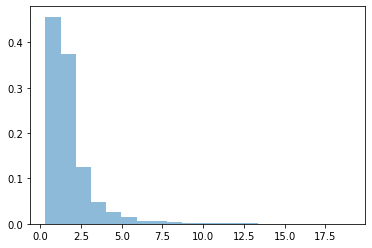

In [74]:
f, ax = plt.subplots()
ax.hist(lac_imp, **hist_args)
plt.show()

In [75]:
alb_imp = impute(
    features=features.iloc[:, :17],
    n_samples=10000,
    model=ALBUMIN_GAM,
    transformer=ALBUMIN_TRANSFORMER,
    random_seed=RANDOM_SEED
)

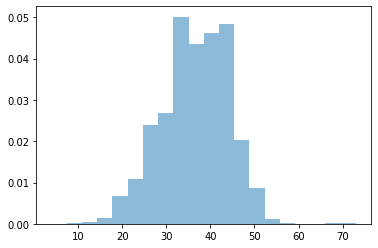

In [76]:
f, ax = plt.subplots()
ax.hist(alb_imp, **hist_args)
plt.show()

## Make plot

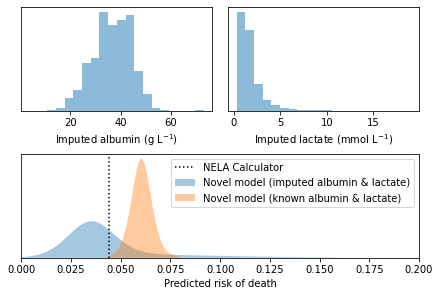

In [77]:
kde_bandwidths = (0.012, 0.004)
labels = (
    'Novel model (imputed albumin & lactate)',
    'Novel model (known albumin & lactate)'
)


fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)


ax0 = fig.add_subplot(spec[0, 0])
ax0.hist(alb_imp, **hist_args)
ax0.axes.yaxis.set_visible(False)
ax0.set(xlabel='Imputed albumin (g L$^{-1}$)')


ax1 = fig.add_subplot(spec[0, 1])
ax1.hist(lac_imp, **hist_args)
ax1.axes.yaxis.set_visible(False)
ax1.set(xlabel='Imputed lactate (mmol L$^{-1}$)')


ax2 = fig.add_subplot(spec[1, :])
ax2.axvline(0.044, c='k', ls=':', label='NELA Calculator')
for i, prediction in enumerate((api_pred_imp, api_pred_noimp)):
    grid, pdf = _kde_linear(
        prediction,
        bw=kde_bandwidths[i],
        bound_correction=False,
        extend=True,
        extend_fct=1.0,
        adaptive=True
    )
    ax2.fill_between(grid, pdf, alpha=0.4, label=labels[i])
ax2.set(
    xlim=(0, 0.2),
    # xlim=(0, 1),
    xlabel='Predicted risk of death',
    ylabel='Probability density'
)
ax2.set_ylim(bottom=0)
ax2.axes.yaxis.set_visible(False)
ax2.legend()


plt.show()

In [120]:
lap_risk_outputs_dir = os.path.join(
    os.pardir,
    os.pardir,
    os.pardir,
    'PycharmProjects',
    'lap-risk-outputs',
    'figures'
)

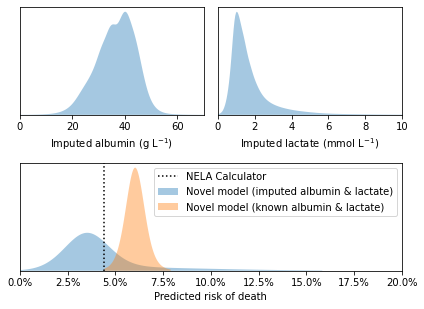

In [122]:
kde_bandwidths = np.array([0.012, 0.004]) * 100
labels = (
    'Novel model (imputed albumin & lactate)',
    'Novel model (known albumin & lactate)'
)


fig = plt.figure(figsize=(6, 4.4))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)


ax0 = fig.add_subplot(spec[0, 0])
grid, pdf = _kde_linear(
    alb_imp,
    bw=1.5,
    bound_correction=False,
    extend=True,
    extend_fct=1.0,
    adaptive=True
)
ax0.fill_between(grid, pdf, alpha=0.4)
ax0.axes.yaxis.set_visible(False)
ax0.set(xlabel='Imputed albumin (g L$^{-1}$)', xlim=(0, 70))
ax0.set_ylim(bottom=0)


ax1 = fig.add_subplot(spec[0, 1])
grid, pdf = _kde_linear(
    lac_imp,
    bw=0.2,
    bound_correction=False,
    extend=True,
    extend_fct=1.0,
    adaptive=True
)
ax1.fill_between(grid, pdf, alpha=0.4)
ax1.axes.yaxis.set_visible(False)
ax1.set(xlabel='Imputed lactate (mmol L$^{-1}$)', xlim=(0, 10))
ax1.set_ylim(bottom=0)


ax2 = fig.add_subplot(spec[1, :])
ax2.axvline(0.044 * 100, c='k', ls=':', label='NELA Calculator')
for i, prediction in enumerate((api_pred_imp, api_pred_noimp)):
    grid, pdf = _kde_linear(
        prediction * 100,
        bw=kde_bandwidths[i],
        bound_correction=False,
        extend=True,
        extend_fct=1.0,
        adaptive=True
    )
    ax2.fill_between(grid, pdf, alpha=0.4, label=labels[i])
ax2.set(
    xlim=(0, 20),
    # xlim=(0, 1),
    xlabel='Predicted risk of death',
    ylabel='Probability density'
)
ax2.set_ylim(bottom=0)
ax2.axes.yaxis.set_visible(False)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter())
ax2.legend()

fig.tight_layout()
fig.savefig(
    os.path.join(lap_risk_outputs_dir, f"case_study.pdf"),
    format='pdf',
    bbox_inches="tight",
)

plt.show()

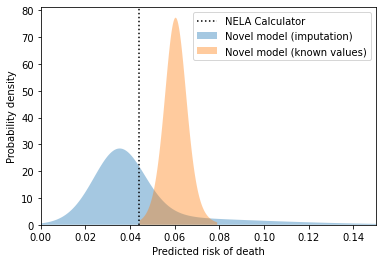

In [92]:
kde_bandwidths = (0.012, 0.004)
labels = (
    'Novel model (imputation)',
    'Novel model (known values)'
)

f, ax = plt.subplots()
ax.axvline(0.044, c='k', ls=':', label='NELA Calculator')
for i, prediction in enumerate((api_pred_imp, api_pred_noimp)):
    grid, pdf = _kde_linear(
        prediction,
        bw=kde_bandwidths[i],
        bound_correction=False,
        extend=True,
        extend_fct=1.0,
        adaptive=True
    )
    ax.fill_between(grid, pdf, alpha=0.4, label=labels[i])
ax.set(
    xlim=(0, 0.15),
    # xlim=(0, 1),
    xlabel='Predicted risk of death',
    ylabel='Probability density'
)
ax.set_ylim(bottom=0)
ax.legend()
plt.show()